# SUMMARY

__Yi Li__

### Methods
-------
Applied two tree-based algorithms a) sklearn random forest classifier and b) light
-gbm classifier on the training dataset. Used mean cross-validation accuracy score 
to evaluate models. The higher the mean cross-validation accuracy score, the better 
the model.
    
For each model:
    1. create a model and set its hyper-parameters search space
    2. tune hyper-paramters based on mean cross-validation accuracy score
    3. apply the best hyper-parameters to the model
    4. fit the model with all training data
    5. if out-of-bag is provided, check the out-of-bag accuracy score (it should 
        be close to best mean cross-validation accuracy socre from tuning results)
   
### Results
-------
    Model1: Random Forest Classifier
        - best mean cross-validation accuary score = 0.8364
        - out-of-bag accuracy score = 0.8429
        - elapsed time: ~30 sec
        
    Model2: LightGBM Classifier
        - best mean cross-validation accuary score = 0.8941
        - elapsed time: ~300 sec
        
    Since model2's best mean cross-validation accuracy is higher than the one of 
    model1's, apply model2 on the test features to obtain test predictions. 


In [2]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from skopt import forest_minimize
from skopt.plots import plot_convergence
%matplotlib inline
warnings.filterwarnings('ignore')

# MacOS: solve OMP libiomp5.dylib initialization problem
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

RANDOM_STATE = 20200216

def load_csv_data(file):
    """Load data from a csv file, data has no header.
    
    Parameters
    ----------
    file : str
        file path
        
    Returns
    -------
    pandas dataframe
        data
    """
    return pd.read_csv(file, header=None)

def process_features(X):
    """Create dummy features for the first three categorical features, 
    and concatenate the remaining numerical features.
    
    Parameters
    ----------
    X : pandas dataframe
        features
        
    Returns
    -------
    X_prcoessed : pandas dataframe
        processed features
    """
    X_processed = pd.concat([
        pd.get_dummies(X.iloc[:, :3]), 
        X.iloc[:, 3:]
    ], axis=1)
    return X_processed

def hyperparams_tuning(model, space):
    """Tune hyper-parameters of a given model.
    
    Use mean cross-validation accuracy score to evaluate model.
    
    Parameters
    ----------
    model : instance
        a sklearn classifer
        
    space : list of skopt space
        a search space of model hyper-parameters
    
    Returns
    -------
    best_params : dict
        a dictionary containing best parameters
        
    best_mean_cross_val_acc_score : float
        best mean cross validation accuracy score 
    """
    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)
        return -np.mean(cross_val_score(model, X_train_processed, y_train, scoring='accuracy', cv=5))

    results = forest_minimize(objective, space, n_calls=20, random_state=RANDOM_STATE)
    
    best_params = dict()
    for i in range(len(space)):
        best_params[space[i].name] = results.x[i]
    
    best_mean_cross_val_acc_score = -results.fun    
    plot_convergence(results)
    return best_params, best_mean_cross_val_acc_score

### Load and Process Data

In [3]:
X_train = load_csv_data('data/train_features.csv')
y_train = load_csv_data('data/train_labels.csv')

X_train_processed = process_features(X_train)
y_train = y_train[0].values

### Model1: Random Forest Classifier

Model1: Random Forest Classifier
Best mean cross-validation accuary score = 0.8364
Best hyper-parameters:
{'n_estimators': 84, 'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 29, 'min_samples_leaf': 1, 'max_features': 181, 'max_leaf_nodes': 6}
out-of-bag accuracy score = 0.8429
Elapsed time: 34 sec


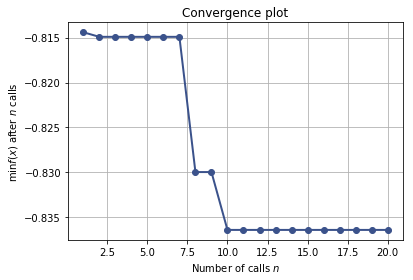

In [4]:
print("Model1: Random Forest Classifier")
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_space = [
    Integer(30, 100, name='n_estimators'),
    Categorical(['gini', 'entropy'], name='criterion'),
    Integer(2, 20, name='max_depth'),
    Integer(2, 50, name='min_samples_split'),
    Integer(1, 10, name='min_samples_leaf'),
    Integer(100, 200, name='max_features'),
    Integer(2, 50, name='max_leaf_nodes')
]

t0 = time.time()
rf_best_params, rf_best_mean_cross_val_acc_score = hyperparams_tuning(rf_model, rf_space)
print("Best mean cross-validation accuary score = {:.4f}".format(rf_best_mean_cross_val_acc_score))
print("Best hyper-parameters:\n{}".format(rf_best_params))

rf_model = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True, **rf_best_params)
rf_model.fit(X_train_processed, y_train)
t1 = time.time()
print("out-of-bag accuracy score = {:.4f}".format(rf_model.oob_score_))
print("Elapsed time: {:.0f} sec".format(t1 - t0))

### Model2: LightGBM Classifier

Model2: LightGBM Classifier
Best mean cross-validation accuary score = 0.8941
Best hyper-parameters:
{'boosting_type': 'dart', 'num_leaves': 46, 'learning_rate': 0.03054682264552107, 'n_estimators': 2392, 'min_split_gain': 0.6542996987224825, 'min_child_weight': 0.008697760032313158, 'min_child_samples': 22, 'reg_alpha': 0.9689513214613142, 'reg_lambda': 0.9707763321177981}
Elapsed time: 311 sec


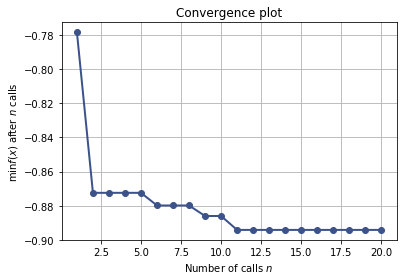

In [5]:
print("Model2: LightGBM Classifier")
lgb_model = LGBMClassifier(random_state=RANDOM_STATE)

lgb_space = [
    Categorical(['gbdt', 'goss', 'dart'], name='boosting_type'),
    Integer(10, 100, name='num_leaves'),
    Real(0.01, 0.1, name='learning_rate'),
    Integer(100, 3000, name='n_estimators'),
    Real(0, 1, name='min_split_gain'),
    Real(0.001, 0.01, name='min_child_weight'),
    Integer(2, 50, name='min_child_samples'),
    Real(0, 1, name='reg_alpha'),
    Real(0, 1, name='reg_lambda')
]

t0 = time.time()
lgb_best_params, lgb_best_mean_cross_val_acc_score = hyperparams_tuning(lgb_model, lgb_space)
print("Best mean cross-validation accuary score = {:.4f}".format(lgb_best_mean_cross_val_acc_score))
print("Best hyper-parameters:\n{}".format(lgb_best_params))

lgb_model = LGBMClassifier(random_state=RANDOM_STATE, **lgb_best_params)
lgb_model.fit(X_train_processed, y_train)
t1 = time.time()
print("Elapsed time: {:.0f} sec".format(t1 - t0))

### Apply the best trained model and get prediction results

In [6]:
print("Applying the LightGBM Classifier on test features...")
X_test = load_csv_data('data/test_features.csv')
assert X_test.shape == (560, 903)

X_test_processed = process_features(X_test)
assert X_test_processed.shape[1] == X_train_processed.shape[1]

y_test_pred = lgb_model.predict(X_test_processed)
test_predictions = pd.DataFrame(y_test_pred)
test_predictions.to_csv("pred_results/test_predictions.csv", index=None, header=None)

Applying the LightGBM Classifier on test features...
